# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Load-Model" data-toc-modified-id="Load-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Model</a></div><div class="lev2 toc-item"><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Set Hyperparameters</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev3 toc-item"><a href="#Language-Model" data-toc-modified-id="Language-Model-431"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Language Model</a></div><div class="lev3 toc-item"><a href="#Qustion-Answering-Model" data-toc-modified-id="Qustion-Answering-Model-432"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Qustion Answering Model</a></div><div class="lev1 toc-item"><a href="#Trian" data-toc-modified-id="Trian-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Trian</a></div>

# Load Data

In [1]:
import json
import os

In [2]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [3]:
premise = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-test.json', 'premise')
asks_for = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-test.json', 'asks-for')
alternative1 = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-test.json', 'alternative1')
alternative2 = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-test.json', 'alternative2')

for i in range(len(premise)):
    if asks_for[i] == 'cause':
        premise[i] += ' What was the CAUSE of this?'
    else:
        premise[i] += ' What happened as a RESULT'

premise.extend(premise)
alternative = []
alternative.extend(alternative1)
alternative.extend(alternative2)

rawLabel = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-test.json', 'most-plausible-alternative')
rawLabel = [int(l) for l in rawLabel]

l = [0] * len(premise)
for i in range(len(rawLabel)):
    if rawLabel[i] == 1:
        l[i] = 1
        l[i+len(rawLabel)] = 0
    if rawLabel[i] == 2:
        l[i] = 0
        l[i+len(rawLabel)] = 1
        
label = l

# Word Segmentation

In [4]:
from nltk import regexp_tokenize
import numpy as np

In [5]:
replDict = {'tattled': 'tattle', 'shirtsleeve': 'shirtsleeves', 'pruny': 'prune', 
            'dry-cleaned': 'dry-clean', 'illegibly': 'illegible', 'unlaced': 'untie', 
            "woman's": 'woman', "man's": 'man', "patient's": 'patient', "student's": 'student', "boy's": 'boy', 
            "friend's": 'friend', "enemy's": 'enemy', "parent's": 'parent', "humanitarian's": 'humanitarian', 
            "child's": 'child', "professor's": 'professor', "daughter's": 'daughter', "mother's": 'mother', 
            "children's": 'children', "teller's": 'teller', "company's": 'company', "group's": 'group', 
            "laptop's": 'laptop', "girl's": 'girl', "salesman's": 'salesman', "cook's": 'cook', "car's": 'car', 
            "offender's": 'offender', "detective's": 'detective', "librarian's": 'librarian', "caller's": 'caller', 
            "victim's": 'victim', "interviewer's": 'interviewer', "ship's": 'ship', "site's": 'site', 
            "chandelier's": 'chandelier', "bully's": 'bully', "river's": 'river', "puppy's": 'puppy', 
            "pilot's": 'pilot', "girlfriend's": 'girlfriend', "politician's": 'politician', "couple's": 'couple', 
            "son's": 'son', "actor's": 'actor', "neighbor's": 'neighbor', "nation's": 'nation', 
            "classmate's": 'classmate', "businessman's": 'businessman', "architect's": 'architect', 
            "imposter's": 'imposter', "kidnapper's": 'kidnapper', "colleague's": 'colleague', "flower's": 'flower',
            "bull's": 'bull', "employee's": 'employee', "wouldn't": 'wouldn', "team's": 'team', "other's": 'other', 
            "writer's": 'writer', "baby's": 'baby', "attacker's": 'attacker', "uncle's": 'uncle', "driver's": 'driver'}

In [6]:
def cut(s):
    """
    Word segmentation
    """
    pattern = r'''
              (?x)                   # set flag to allow verbose regexps 
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A. 
              |\w+(?:[-&']\w+)*      # words w/ optional internal hyphens/apostrophe  
            '''  
    return regexp_tokenize(s, pattern=pattern)

def clean(s):
    """
    Clean data
    """
    for i in range(len(s)):
        for d in ['0', '1', '2', '3', '4', '5' ,'6', '7', '8', '9']:
            if d in s[i]:
                s[i] = '0'
        if s[i] == 'p' and i < len(s)-1:
            if s[i+1] == 'm':
                s[i] = 'pm'
                s[i+1] = ''
        if s[i] == 'a' and i < len(s)-1:
            if s[i+1] == 'm':
                s[i] = 'am'
                s[i+1] = ''
        if s[i] == 's':
            s[i] = ''
        if s[i].endswith("'s"):
            s[i] = s[i][:-2]
        if s[i] == "couldn't":
            s[i] = 'could'
            s.insert(i+1, 'not')
    s = [i for i in s if i != '']
    return [replDict.get(i.lower(), i.lower()) for i in s]

In [7]:
pWords = [clean(cut(s)) for s in premise]
aWords = [clean(cut(s)) for s in alternative]

In [8]:
MAX_P_LEN = 19
MAX_A_LEN = 11
SEED = 42

#  Tokenize Text

In [9]:
from nltk import PorterStemmer, LancasterStemmer, WordNetLemmatizer
import pickle
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [10]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/index.pkl', 'rb') as fp:
    word2index, index2word, glove_index2index = pickle.load(fp)

In [11]:
wnl = WordNetLemmatizer()
porter = PorterStemmer()
lancaster = LancasterStemmer()

R = []
for i in sum(pWords+aWords, []):
    if word2index[i] > 19994:
        R.append(i)
N = {i: i for i in R}

mini_word2index = {i: word2index[i] for i in word2index if word2index[i] <= 19994}
count = 0
for i in N:
    w = N[i]
    g = mini_word2index.get(w)
    if g is None:
        ww = wnl.lemmatize(w)
        g = mini_word2index.get(ww)
    if g is None:
        ww = porter.stem(w)
        g = mini_word2index.get(ww)
    if g is None:
        ww = lancaster.stem(w)
        g = mini_word2index.get(ww)
    if g is None:
        if w.endswith('ed') or w.endswith('s'):
            ww = w[:-1]
            g = mini_word2index.get(ww)
    if g is None:
        if w.endswith('ed') or w.endswith('es') or w.endswith('er') or w.endswith('ly'):
            ww = w[:-2]
            g = mini_word2index.get(ww)
    if g is None:
        if w.endswith('ily') or w.endswith('ing'):
            ww = w[:-3]
            g = mini_word2index.get(ww)
    if g is not None:
        N[i] = index2word[g]
        count += 1
print('{num_tokens}-{per:.2f}% tokens was replaced.'.format(num_tokens=count, per=count/float(len(N))*100))    

103-34.68% tokens was replaced.


In [12]:
pWords = [[N.get(i.lower(), i.lower()) for i in s] for s in pWords]
aWords = [[N.get(i.lower(), i.lower()) for i in s] for s in aWords]

In [13]:
NUM_GRAMS = 25
NUM_UNK_WORDS = 5
VOCAB_SIZE = 20000
MAX_P_LEN = 19
MAX_A_LEN = 11
SEED = 42

In [14]:
for i in range(NUM_UNK_WORDS):
    index2word[VOCAB_SIZE-1-i] = '<%d>'%i

unk0 = VOCAB_SIZE - NUM_UNK_WORDS

In [15]:
def vocab_fold(xs):
    """
    Convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < unk0 else glove_index2index.get(x, x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= unk0])
    # if there are more than unknown_words unk words then put them all in unknown_words-1
    outside = {x: VOCAB_SIZE-1-min(i, NUM_UNK_WORDS-1) for i, x in enumerate(outside)}
    xs = [outside.get(x, x) for x in xs]
    return xs

In [18]:
pSeq = [[word2index.get(w, w) for w in s] for s in pWords]
pSeq = [vocab_fold(s) for s in pSeq]
aSeq = [[word2index.get(w, w) for w in s] for s in aWords]
aSeq = [vocab_fold(s) for s in aSeq]

xp = pad_sequences(pSeq, maxlen=MAX_P_LEN)
xa = pad_sequences(aSeq, maxlen=MAX_A_LEN)
#y = np.array(label)

#xpTrain, _, yTrain, _ = train_test_split(xp, y, test_size=0., random_state=SEED)
#xaTrain, _ = train_test_split(xa, test_size=0., random_state=SEED)

xpTest = xp[:500]
xa1Test = xa[:500]
xa2Test =  xa[500:]
yTest = np.array(rawLabel)

In [19]:
import h5py

In [20]:
fh = h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/Question_Answering_Hinge/data/test.h5', 'w')
fh['xpTest'] = xpTest
fh['xa1Test'] = xa1Test
fh['xa2Test'] = xa2Test
fh['yTest'] = yTest
fh.close()

In [22]:
fh = h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/Question_Answering_Hinge/data/train.h5', 'w')
fh['xpTrain'] = xpTrain
fh['xaTrain'] = xaTrain
fh['yTrain'] = yTrain
fh.close()

# Load Model

## Set Hyperparameters

In [191]:
NUM_GRAMS = 25
MAX_P_LEN = 21
MAX_A_LEN = 12
VOCAB_SIZE = 20000
EMBEDDING_DIM = 200
TUNE = True
BATCH_SIZE = 1024
RNN_SIZE = 1024
HIDDEN_SIZE_1 = 8
HIDDEN_SIZE_2 = 256
NUM_EPOCHS = 64

## Import Libraries

In [143]:
from keras.layers import Input, Embedding, LSTM, Reshape, MaxPooling1D, Flatten, Activation, dot, Dense, Dropout
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Build Graph

### Language Model

In [19]:
import h5py

In [129]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:]

In [21]:
K.clear_session()
# Encoder
inputs = Input(shape=(None,), name='EN_INPUT', dtype='int64')
emb_seq = Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    weights=[embedding], 
                    mask_zero=True, 
                    trainable=TUNE, 
                    name='EN_EMBEDDING')(inputs)
lstm = LSTM(RNN_SIZE, return_sequences=False, implementation=0, name='EN_LSTM')(emb_seq)
encoder = Model(inputs=inputs, outputs=lstm)

# Language Model
input_grams = Input(shape=(NUM_GRAMS,), name='LM_INPUT', dtype='int64')
encoded_grams = encoder(input_grams)
outputs = Dense(VOCAB_SIZE, activation='softmax', name='LM_OUTPUT')(encoded_grams)
lm = Model(inputs=input_grams, outputs=outputs)
lm.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EN_INPUT (InputLayer)        (None, None)              0         
_________________________________________________________________
EN_EMBEDDING (Embedding)     (None, None, 200)         4000000   
_________________________________________________________________
EN_LSTM (LSTM)               (None, 1024)              5017600   
Total params: 9,017,600
Trainable params: 9,017,600
Non-trainable params: 0
_________________________________________________________________


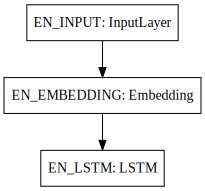

In [22]:
encoder.summary()
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LM_INPUT (InputLayer)        (None, 25)                0         
_________________________________________________________________
model_1 (Model)              (None, 1024)              9017600   
_________________________________________________________________
LM_OUTPUT (Dense)            (None, 20000)             20500000  
Total params: 29,517,600
Trainable params: 29,517,600
Non-trainable params: 0
_________________________________________________________________


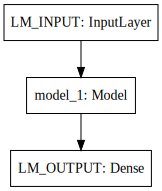

In [23]:
lm.summary()
SVG(model_to_dot(lm).create(prog='dot', format='svg'))

### Qustion Answering Model 

In [195]:
def cosine_similarity(x, y):
    """
    Compute_cosine_similarity
    """
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))

In [196]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/cp_logs/weights.053-4.498228.hdf5'
lm.load_weights(filename)

In [197]:
for layer in encoder.layers:
    layer.trainable = False

def build():
    """
    Build encoder model
    """
    sentence = Input(shape=(None,))
    encoded_sentence = encoder(sentence)
    encoded_sentence = Reshape((RNN_SIZE, 1))(encoded_sentence)
    encoded_sentence = MaxPooling1D(pool_size=2)(encoded_sentence)
    encoded_sentence = Flatten()(encoded_sentence)
    encoded_sentence = Activation('tanh')(encoded_sentence)
    model = Model(inputs=sentence, outputs=encoded_sentence)
    return model

In [198]:
model = build()

In [199]:
p, a = Input(shape=(MAX_P_LEN,)), Input(shape=(MAX_A_LEN,))
pSeq, aSeq = model(p), model(a)
pSeq = Dense(HIDDEN_SIZE_1, activation='tanh')(pSeq)
aSeq = Dense(HIDDEN_SIZE_1, activation='tanh')(aSeq)
#pSeq = Dense(HIDDEN_SIZE_2, activation='tanh')(pSeq)
#aSeq = Dense(HIDDEN_SIZE_2, activation='tanh')(aSeq)
similarity = dot([pSeq, aSeq], axes=-1, normalize=True)
model = Model(inputs=[p, a], outputs=[similarity])
model.compile(loss='categorical_hinge', optimizer='sgd', metrics=['accuracy'])

In [200]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_67 (InputLayer)            (None, 21)            0                                            
____________________________________________________________________________________________________
input_68 (InputLayer)            (None, 12)            0                                            
____________________________________________________________________________________________________
model_40 (Model)                 (None, 512)           9017600     input_67[0][0]                   
                                                                   input_68[0][0]                   
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 8)             4104        model_40[1][0]          

# Trian

In [201]:
history = model.fit([xpTrain, xaTrain], 
                    yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    #callbacks=callbacks_list,
                    validation_data=([xpVal, xaVal], yVal),
                    shuffle=True)

Train on 800 samples, validate on 200 samples
Epoch 1/64
800/800 [==============================] - 11s - loss: 1.0215 - acc: 0.4487 - val_loss: 0.9625 - val_acc: 0.4800
Epoch 2/64
800/800 [==============================] - 10s - loss: 1.0209 - acc: 0.4525 - val_loss: 0.9638 - val_acc: 0.4800
Epoch 3/64
800/800 [==============================] - 10s - loss: 1.0203 - acc: 0.4563 - val_loss: 0.9651 - val_acc: 0.4950
Epoch 4/64
800/800 [==============================] - 9s - loss: 1.0196 - acc: 0.4575 - val_loss: 0.9664 - val_acc: 0.5100
Epoch 5/64
800/800 [==============================] - 9s - loss: 1.0190 - acc: 0.4575 - val_loss: 0.9677 - val_acc: 0.5150
Epoch 6/64
800/800 [==============================] - 9s - loss: 1.0184 - acc: 0.4625 - val_loss: 0.9691 - val_acc: 0.5200
Epoch 7/64
800/800 [==============================] - 9s - loss: 1.0178 - acc: 0.4638 - val_loss: 0.9705 - val_acc: 0.5300
Epoch 8/64
800/800 [==============================] - 9s - loss: 1.0171 - acc: 0.4663 - va

KeyboardInterrupt: 